<a href="https://colab.research.google.com/github/yminomo/q_macro_sept/blob/main/kadai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

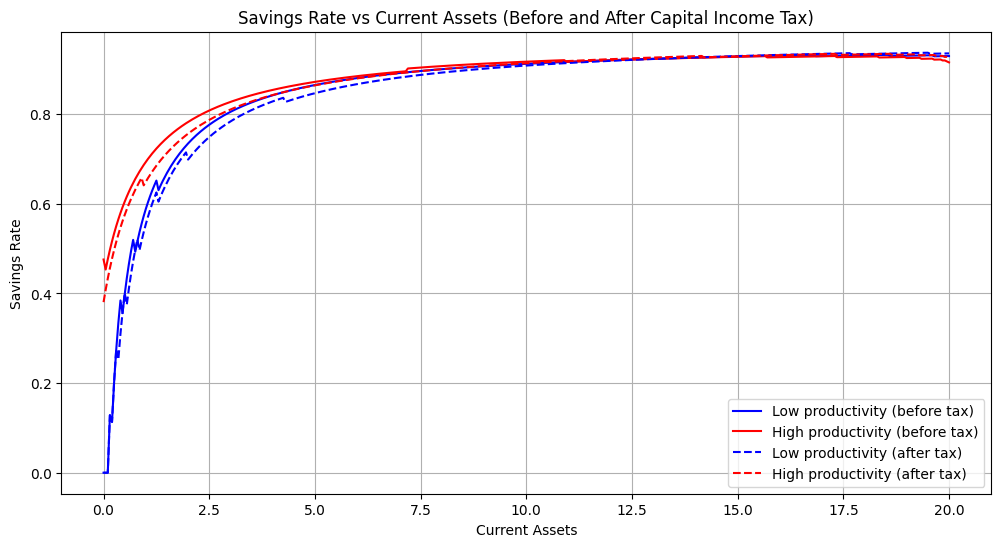

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# tauchen method
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, np.exp(state_space)

def solve_household(param, r, w, tau_k):
    NA, NH = param['NA'], param['NH']
    h, a_l, a_u = param['h'], param['a_l'], param['a_u']
    sigma, beta, pi = param['sigma'], param['beta'], param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -np.inf)

    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                # considering capital income tax
                cons = w*h[ih] + (1.0 + (1 - tau_k)*r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -1)

    tol = 1e-6
    while True:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih] + beta * (pi[ih, 0] * v[:, 0] + pi[ih, 1] * v[:, 1])
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)

        if np.max(np.abs(v_new - v)) < tol:
            break
        v = v_new.copy()

    aplus = a[iaplus]
    c = w * h[np.newaxis, :] + (1.0 + (1 - tau_k)*r) * a[:, np.newaxis] - aplus

    return aplus, c

# Parameters
param = {
    'sigma': 1.5,
    'beta': 0.98,
    'rho': 0.6,
    'sigma_eps': 0.6,
    'a_l': 0,
    'a_u': 20,
    'NA': 401,
    'NH': 2,
    'mu_h': -0.7,
}

# Productivity grid and transition probability calculations
param['pi'], param['h'] = tauchen(param['NH'], param['mu_h'], param['rho'], param['sigma_eps'])

# Pricing
r, w = 0.04, 1

# capital income tax rate
tau_k = 0.3

# Solving household before tax introduction
aplus_before, c_before = solve_household(param, r, w, 0)

# Solving household after tax introduction
aplus_after, c_after = solve_household(param, r, w, tau_k)

# Plot
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plt.figure(figsize=(12, 6))

# Befor tax introduction
plt.plot(a, aplus_before[:, 0] / (c_before[:, 0] + aplus_before[:, 0]), label='Low productivity (before tax)', color='blue')
plt.plot(a, aplus_before[:, 1] / (c_before[:, 1] + aplus_before[:, 1]), label='High productivity (before tax)', color='red')

# After tax introduction
plt.plot(a, aplus_after[:, 0] / (c_after[:, 0] + aplus_after[:, 0]), label='Low productivity (after tax)', color='blue', linestyle='--')
plt.plot(a, aplus_after[:, 1] / (c_after[:, 1] + aplus_after[:, 1]), label='High productivity (after tax)', color='red', linestyle='--')

plt.xlabel('Current Assets')
plt.ylabel('Savings Rate')
plt.title('Savings Rate vs Current Assets (Before and After Capital Income Tax)')
plt.legend()
plt.grid(True)
plt.show()